In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt

from torch import tensor
from torch import cat
from torch import clamp
from torch.distributions import normal
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torch

import mujoco_py
import gym

In [2]:
environment_name = 'Hopper-v2'

model_name = "SAC-{}".format(environment_name)

parameters = {
    'state_dim': {
        'LunarLanderContinuous-v2': 8,
        'Hopper-v2': 11
    },
    'action_dim': {
        'LunarLanderContinuous-v2': 2,
        'Hopper-v2': 3
    },
    'hidden_layer_size': {
        'LunarLanderContinuous-v2': 100,
        'Hopper-v2': 256
    }
}

STATE_DIM = parameters['state_dim'][environment_name]
ACTION_DIM = parameters['action_dim'][environment_name]
hidden_layer_size = parameters['hidden_layer_size'][environment_name]

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu_device = torch.device("cpu")

In [4]:
# define actor network
class SACActorNN(nn.Module):
    def __init__(self):
        super(SACActorNN, self).__init__()
        self.fc1 = nn.Linear(STATE_DIM, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.mean = nn.Linear(hidden_layer_size, ACTION_DIM)
        self.log_stdev = nn.Linear(hidden_layer_size, ACTION_DIM)
        self.normal_dist = normal.Normal(0, 1)


    def forward(self, x_state):
        # print(x_state.shape)
        x_state = F.relu(self.fc1(x_state))
        x_state = F.relu(self.fc2(x_state))
        mean = self.mean(x_state)
        log_stdev = clamp(self.log_stdev(x_state), min=-2, max=20)
        unsquashed_action = mean + self.normal_dist.sample(sample_shape=log_stdev.shape).to(device) * torch.exp(log_stdev).to(device)
        squashed_action = torch.tanh(unsquashed_action)
        action_dist = normal.Normal(mean, torch.exp(log_stdev))
        log_prob_squashed_a = action_dist.log_prob(unsquashed_action).to(device) - torch.sum(torch.log(clamp(torch.ones(squashed_action.shape).to(device) - squashed_action**2, min=1e-8)), dim=1).view(-1, 1).repeat(1, ACTION_DIM)
        return squashed_action, log_prob_squashed_a

In [5]:
actor_net = SACActorNN().to(device)
actor_net.load_state_dict(torch.load("./models/current/best/v11-1mil-iter-256-node-hidden-layers-buffer-1mil/best-SAC-Hopper-v2-actor_net.pkl"))
env = gym.make(environment_name)

In [6]:
render = False
num_eval_episodes = 100

obs = env.reset()
episode_rewards = []
episode_reward = 0
while len(episode_rewards) < num_eval_episodes:
    action, log_prob = actor_net(tensor(obs).view(1, -1, ).float().to(device))
    action = action.detach().to(cpu_device).numpy().squeeze()
    log_prob = log_prob.detach()
    obs, reward, done, _ = env.step(action)
    episode_reward += reward
    if done:
        episode_rewards.append(episode_reward)
        episode_reward = 0
        obs = env.reset()
    if render:
        env.render()

In [7]:
env.close()
episode_rewards = np.asarray(episode_rewards)

Mean total episode reward: 3009.8156368252367


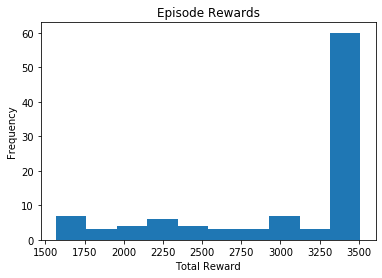

In [8]:
episode_length_histogram = plt.hist(episode_rewards)
plt.title("Episode Rewards")
plt.xlabel("Total Reward")
plt.ylabel("Frequency")
plt.plot()
print("Mean total episode reward:", np.mean(episode_rewards))